In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [ ]:
# For Google Colab, this line installs NEURON
!pip install neuron

In [3]:
import neuron

In [4]:
from neuron import h
from neuron.units import ms, mV, µm, cm

In [5]:
h.load_file("stdrun.hoc")

1.0

In [70]:
from numpy import sqrt, pi
import numpy as np

In [7]:
soma = h.Section()

In [8]:
soma.L = 10 * µm
soma.diam =  10 * µm

In [9]:
soma.nseg

1

In [10]:
soma(0.5).volume()

785.3981633974483

In [11]:
A = soma(0.5).area()

In [12]:
f = soma(0.5).area

In [13]:
help(f)

Help on built-in function area:

area(...) method of nrn.Segment instance
    Segment area (um2) (same as h.area(sec(x), sec=sec))



In [14]:
A

314.1592653589793

In [15]:
Acm2 = A*1e-4*1e-4

In [16]:
Acm2

3.1415926535897938e-06

In [17]:
soma.insert("pas")

__nrnsec_0x5583fea46010

In [18]:
for sec in soma.wholetree():
    sec.Ra = 100  # Axial resistance in Ohm * cm
    sec.cm = 1  # Membrane capacitance in micro Farads / cm^2

In [19]:
h.units("g_pas")

'S/cm2'

In [73]:
h.units("cm")

'uF/cm2'

In [56]:
G = 5 #nS

In [57]:
for seg in soma:
    seg.pas.g = G/1e9/(Acm2) # 20 nS over the area A expressed in units of 'S/cm2'

In [58]:
soma.psection()

{'point_processes': {'IClamp': {IClamp[0]}},
 'density_mechs': {'pas': {'g': [0.0015915494309189531],
   'e': [-70.0],
   'i': [2.7140733281822007e-16]}},
 'ions': {},
 'morphology': {'L': 10.0,
  'diam': [10.0],
  'pts3d': [],
  'parent': None,
  'trueparent': None},
 'nseg': 1,
 'Ra': 100.0,
 'cm': [1.0],
 'regions': set(),
 'species': set(),
 'name': '__nrnsec_0x5583fea46010',
 'hoc_internal_name': '__nrnsec_0x5583fea46010',
 'cell': None}

In [22]:
stim = h.IClamp(soma(0.5))

In [60]:
stim.delay = 500
stim.dur = 20
stim.amp = 0.1

In [61]:
stim.amp

0.1

In [93]:
soma_v = h.Vector().record(soma(0.5)._ref_v)
g_i = h.Vector().record(soma(0.5).pas._ref_i)
t = h.Vector().record(h._ref_t)

In [94]:
h.finitialize(-70 * mV)

1.0

In [95]:
h.t

0.0

In [96]:
h.dt

0.025

In [97]:
h.continuerun(1500 * ms)

0.0

In [98]:
v_infinity = soma(0.5).pas.e + stim.amp / G * 1000

In [99]:
v_infinity

-50.0

In [100]:
tau = soma(0.5).cm / soma(0.5).pas.g / 1000 # convert from µs to ms

In [101]:
tau

0.6283185307179587

In [102]:
v_rest = soma(0.5).pas.e

In [103]:
t_theory = np.arange(500,520, 0.1)
v_theory = v_rest + (v_infinity-v_rest)*(1-np.exp(-(t_theory-500)/tau))

(array([-75., -70., -65., -60., -55., -50., -45., -40., -35.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

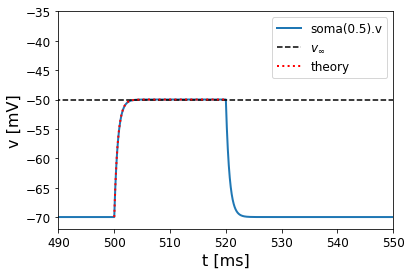

In [104]:
plt.plot(t, soma_v, lw=2, label="soma(0.5).v")
plt.plot([t[0],t[-1]], [v_infinity, v_infinity], 'k--', label="$v_\infty$")
plt.plot(t_theory, v_theory, 'r:', lw=2, label="theory")
plt.axis([490,550,-72, -35])
plt.legend(fontsize=12)
plt.xlabel("t [ms]", size=16)
plt.ylabel("v [mV]", size=16)
plt.xticks(size=12)
plt.yticks(size=12)

(490.0, 550.0, 0.0, 0.11)

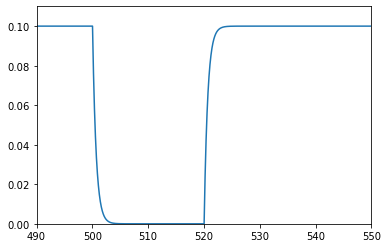

In [117]:
# Current on capacitor is stim.amp - current across pas.g (=pas.g.i; as recorded above into g_i)
plt.plot(t, stim.amp - Acm2*g_i*1e6)
plt.axis([490,550,0, 0.11])